In [23]:
import pandas as pd
import requests as r
import plotly.express as px
import plotly.graph_objects as go

In [24]:
def clear_transpose(df, num, state):
    df = df.drop(["Province/State", "Country/Region", "Lat", "Long"],1)
    df = df.transpose()
    df = df.rename(columns={num: state})
    df = df[df[state] > 0]
    mapper = {}
    for i, date in enumerate(df.index.values.tolist()):
        mapper.update({date:i})
    df = df.rename(mapper, axis='index')
    return df

italy = 60480000
czech = 10650000
ratio = italy/czech
print(ratio)

5.67887323943662


In [25]:
conf_gl = pd.read_csv("COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv")
deaths_gl = pd.read_csv("COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv")

In [26]:
cof_gl_it = conf_gl[conf_gl["Country/Region"] == "Italy"]
cof_gl_cz = conf_gl[conf_gl["Country/Region"] == "Czechia"]

In [27]:
cof_gl_it = clear_transpose(cof_gl_it, 137, "Italy")
cof_gl_cz = clear_transpose(cof_gl_cz, 91, "Czechia")

,Italy,Czechia
0,2,17.036620
1,2,17.036620
2,2,28.394366
3,2,45.430986
4,2,68.146479


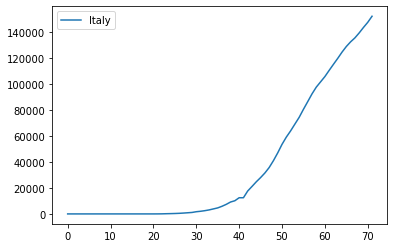

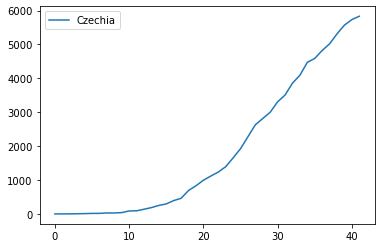

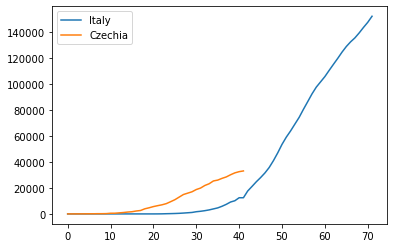

In [28]:
cof_gl_it.plot.line()
cof_gl_cz.plot.line()

summary = pd.concat([cof_gl_it["Italy"], cof_gl_cz["Czechia"]], axis=1, keys=['Italy', 'Czechia'])
summary["Czechia"] = summary["Czechia"].apply(lambda x: x * ratio)
summary.plot.line()
summary.head()

In [29]:
deaths_gl_it = deaths_gl[deaths_gl["Country/Region"] == "Italy"]
deaths_gl_cz = deaths_gl[deaths_gl["Country/Region"] == "Czechia"]

In [30]:
deaths_gl_it = clear_transpose(deaths_gl_it, 137, "Italy")
deaths_gl_cz = clear_transpose(deaths_gl_cz, 91, "Czechia")

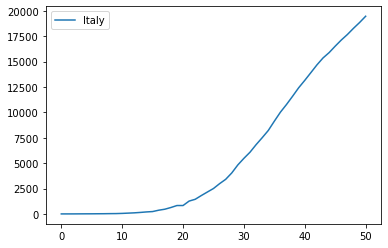

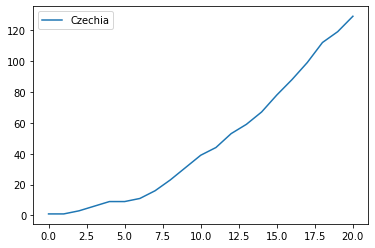

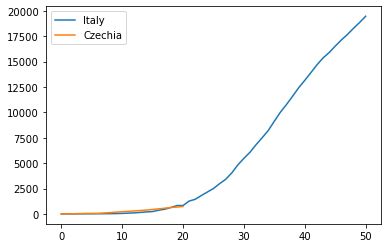

In [31]:
deaths_gl_it.plot.line()
deaths_gl_cz.plot.line()

summary_deaths = pd.concat([deaths_gl_it["Italy"], deaths_gl_cz["Czechia"]], axis=1, keys=['Italy', 'Czechia'])
summary_deaths["Czechia"] = summary_deaths["Czechia"].apply(lambda x: x * ratio)
summary_deaths.plot.line()

In [32]:
fig = go.Figure()
fig.add_trace(go.Scatter(y=summary_deaths["Italy"],
                    mode='lines',
                   name='Italy'))
fig.add_trace(go.Scatter(y=summary_deaths["Czechia"],
                    mode='lines',
                   name='Czechia'))

In [33]:
fig = go.Figure()
fig.add_trace(go.Scatter(y=summary["Italy"],
                    mode='lines',
                   name='Italy'))
fig.add_trace(go.Scatter(y=summary["Czechia"],
                    mode='lines',
                   name='Czechia'))